In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("powerplant_data.csv")

In [3]:
df.head()

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


###### AT => Temperature
###### V => Vaccume
###### AP => Pressure
###### PH => Humidity
###### PE => Produced Energy

In [4]:
df.isnull().sum()

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

In [5]:
X = df.drop("PE", axis=1)
y = df["PE"]

In [6]:
X.head()

,AT,V,AP,RH
0,8.34,40.77,1010.84,90.01
1,23.64,58.49,1011.40,74.20
2,29.74,56.90,1007.15,41.91
3,19.07,49.69,1007.22,76.79
4,11.80,40.66,1017.13,97.20


In [7]:
y.head()

0    480.48
1    445.75
2    438.76
3    453.09
4    464.43
Name: PE, dtype: float64

In [8]:
# Split out data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [9]:
df.shape

(9568, 5)

### scaled data

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Tensor Creation

In [11]:
import torch
import torch.nn as nn

In [12]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1,1)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1,1)

In [13]:
type(X_train_scaled)

numpy.ndarray

In [14]:
type(y_train)

pandas.Series

In [15]:
y_train.shape

(7654,)

In [16]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [17]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32) 

# Deep Learning

In [18]:
# Build our ANN Model:

class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()

        self.model = nn.Sequential(
            # 1st hidden layer
            nn.Linear(X_train.shape[1], 6),
            nn.ReLU(),

            # 2nd Hidden Layer
            nn.Linear(6, 6),
            nn.ReLU(),

            # Output Layer
            nn.Linear(6, 1),
        )

    def forward(self, x):
        return self.model(x)

In [19]:
import torch.optim as optim

model = ANN()

# loss, optimizer
crietrian = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [20]:
# Train the ANN

train_losses = []
val_losses = []

best_val_loss = float("inf")

epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0; # total training loss for 1 epoch

    for xb, yb in train_loader:
        # xb = features of 1 batch -> inputs
        # yb = lables of 1 batch -> outputs
        optimizer.zero_grad()

        outputs = model(xb) # forward prop... predicted outputs for this batch
        loss = crietrian(outputs, yb) # compute loss
        loss.backward() # back prop... compute gradients
        optimizer.step() # parameters update

        running_loss += loss.item() # loss is a tensor -> py float

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # validation
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad(): # no gradients compute
        for xb, yb in test_loader:
            outputs = model(xb)
            loss = crietrian(outputs, yb)
            running_val_loss += loss

    epoch_val_loss = running_val_loss / len(test_loader)
    val_losses.append(epoch_val_loss)

    print(f"epoch {epoch+1}/{epochs} ==> train loss = {epoch_train_loss} & val loss = {epoch_val_loss}")
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), "best_model.pt") # .pt or .pth

epoch 1/100 ==> train loss = 206509.1857421875 & val loss = 205387.109375
epoch 2/100 ==> train loss = 201557.22897135417 & val loss = 194944.4375
epoch 3/100 ==> train loss = 182065.60130208332 & val loss = 165429.953125
epoch 4/100 ==> train loss = 142417.092578125 & val loss = 116728.171875
epoch 5/100 ==> train loss = 87725.29969075522 & val loss = 64724.6953125
epoch 6/100 ==> train loss = 45748.29969889323 & val loss = 35851.4921875
epoch 7/100 ==> train loss = 26178.51444905599 & val loss = 23427.34375
epoch 8/100 ==> train loss = 17924.483841959634 & val loss = 17118.451171875
epoch 9/100 ==> train loss = 13514.99950358073 & val loss = 13136.8974609375
epoch 10/100 ==> train loss = 10517.011177571614 & val loss = 10220.396484375
epoch 11/100 ==> train loss = 8118.987034098307 & val loss = 7934.75
epoch 12/100 ==> train loss = 6208.819029744466 & val loss = 6091.9326171875
epoch 13/100 ==> train loss = 4647.250631713867 & val loss = 4619.50537109375
epoch 14/100 ==> train loss =

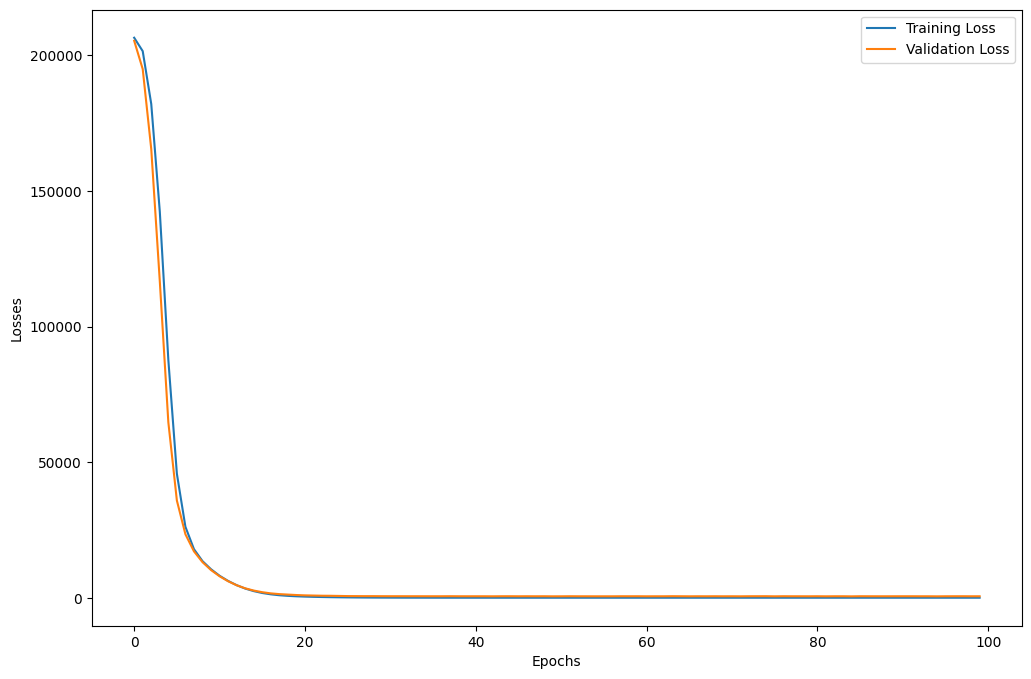

In [21]:
import matplotlib.pyplot as plt

loss_df = pd.DataFrame({
    "Training Loss": train_losses,
    "Validataion Loss": val_losses
})

plt.figure(figsize=(12,8))
plt.plot(loss_df["Training Loss"], label="Training Loss")
plt.plot(loss_df["Validataion Loss"], label="Validation Loss")

plt.xlabel("Epochs");
plt.ylabel("Losses");
plt.legend()

# Loading and saving best model

###### with each epoch there are different learnable parameters (w-> weights, b-> bias)
###### best model is the one having loss should be minimal 
###### there are basically two different parameters -> training & validation 
###### we have to minimize the validation loss because it is being calculated on untrained data sets

###### So, set the parameters with having validation loss as minimal

In [22]:
# Loading the best model 

model.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

In [ ]:
# Evaluation

model.eval()
with torch.no_grad():
    train_preds = model(X_train_tensor)
    train_mse_loss = crietrian(train_preds, y_train_tensor);

with torch.no_grad():
    test_preds = model(X_test_tensor)
    test_mse_loss = crietrian(test_preds, y_test_tensor);

print("Training MSE: ", train_mse_loss.item())
print("Test MSE: ", test_mse_loss.item())

c:\Users\Admin\AppData\Local\Programs\Python\Python314\Lib\site-packages\torch\nn\modules\loss.py:626: UserWarning: Using a target size (torch.Size([7654, 1])) that is different to the input size (torch.Size([1914, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (1914) must match the size of tensor b (7654) at non-singleton dimension 0

In [ ]:
from sklearn.metrics import r2_score

print("r2_score =", r2_score(y_test, test_preds))

r2_score = 0.9279197781759697


In [ ]:
predicted_df = pd.DataFrame(test_preds.numpy(), columns=["Predicted Values"])
actual_df = pd.DataFrame(y_test.values, columns=["Actual Values"])

pd.concat([predicted_df, actual_df], axis=1)

,Predicted Values,Actual Values
0,436.919250,433.27
1,438.405579,438.16
2,460.369659,458.42
3,474.368622,480.82
4,436.662842,441.41
...,...,...
1909,451.599518,456.70
1910,433.422974,438.04
1911,467.118866,467.80
1912,432.943420,437.14
